In [121]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss
from pytorch_forecasting.data import GroupNormalizer

In [164]:
from preprocess_raw_parquet import preprocess_raw_parquet
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
from transform_fee_data_dl import transform_fee_data_dl
df = transform_fee_data_dl(df)
df.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_250_300,time_idx,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,minute_sin,minute_cos
0,2025-03-05 02:00:00,recommended_fee_economyFee,2.000000,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,7971.000000,4.809659e+07,...,0.0,0,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00
1,2025-03-05 02:15:00,recommended_fee_economyFee,2.666667,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,9943.333333,4.946978e+07,...,0.0,1,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,1.000000e+00,2.832769e-16
2,2025-03-05 02:30:00,recommended_fee_economyFee,2.000000,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,8189.333333,4.936482e+07,...,0.0,2,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,5.665539e-16,-1.000000e+00
3,2025-03-05 02:45:00,recommended_fee_economyFee,2.333333,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,8874.666667,5.061585e+07,...,0.0,3,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,-1.000000e+00,-1.836970e-16
4,2025-03-05 03:00:00,recommended_fee_economyFee,3.000000,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,11247.333333,5.158261e+07,...,0.0,4,0.707107,0.707107,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00


In [167]:
FREQ = "15min"  # Frequency of the time series: one data point every 15 minutes.
ENC_LEN = 672  # Length of the encoder input (7 days): 672 × 15min = 7 days.
PRED_STEPS = 96  # Forecasting horizon (1 day): 96 × 15min = 24 hours.

VAL_DAYS = 1  # Number of days used for validation.
TEST_DAYS = 1  # Number of days used for testing (final block evaluation).

BATCH_SIZE = 128  # Number of samples per batch for model training.
NUM_WORKERS = 4  # Number of CPU threads used for data loading.

In [169]:
from split_and_scale import split_and_scale
last_idx = df.time_idx.max() - PRED_STEPS
training_cutoff = last_idx - PRED_STEPS
df_train, df_valid, scaler = split_and_scale(df, PRED_STEPS)
df_train

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_250_300,time_idx,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,minute_sin,minute_cos
0,2025-03-05 02:00:00,recommended_fee_economyFee,2.000000,1.718776,0.315714,-1.946223,-0.714628,-0.480730,-0.409374,2.866116,...,0.0,0,0.500000,8.660254e-01,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00
1,2025-03-05 02:15:00,recommended_fee_economyFee,2.666667,0.592171,0.315926,-0.147425,-0.204269,-0.091919,-0.195878,2.980191,...,0.0,1,0.500000,8.660254e-01,0.974928,-0.222521,1.0,6.123234e-17,1.000000e+00,2.832769e-16
2,2025-03-05 02:30:00,recommended_fee_economyFee,2.000000,1.366235,0.316204,-1.819699,-0.711815,-0.462252,-0.385740,2.971472,...,0.0,2,0.500000,8.660254e-01,0.974928,-0.222521,1.0,6.123234e-17,5.665539e-16,-1.000000e+00
3,2025-03-05 02:45:00,recommended_fee_economyFee,2.333333,1.218178,0.316233,-1.452224,-0.609854,-0.402567,-0.311556,3.075400,...,0.0,3,0.500000,8.660254e-01,0.974928,-0.222521,1.0,6.123234e-17,-1.000000e+00,-1.836970e-16
4,2025-03-05 03:00:00,recommended_fee_economyFee,3.000000,0.507187,0.316165,-0.050980,-0.186345,-0.094006,-0.054725,3.155711,...,0.0,4,0.707107,7.071068e-01,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32803,2025-05-10 18:45:00,recommended_fee_minimumFee,1.000000,0.545227,0.024555,-1.406780,-0.786850,-0.576604,-1.124445,-1.042528,...,0.0,6403,-1.000000,-1.836970e-16,-0.974928,-0.222521,0.5,-8.660254e-01,-1.000000e+00,-1.836970e-16
32804,2025-05-10 19:00:00,recommended_fee_minimumFee,1.000000,0.911975,0.316220,-1.478379,-0.701846,-0.456870,-1.074796,-0.979306,...,0.0,6404,-0.965926,2.588190e-01,-0.974928,-0.222521,0.5,-8.660254e-01,0.000000e+00,1.000000e+00
32805,2025-05-10 19:15:00,recommended_fee_minimumFee,1.000000,1.041914,0.316077,-1.412665,-0.660526,-0.468511,-1.070430,-0.973062,...,0.0,6405,-0.965926,2.588190e-01,-0.974928,-0.222521,0.5,-8.660254e-01,1.000000e+00,2.832769e-16
32806,2025-05-10 19:30:00,recommended_fee_minimumFee,1.000000,0.367899,0.316012,0.047755,0.024015,-0.115466,-0.875336,-0.909620,...,0.0,6406,-0.965926,2.588190e-01,-0.974928,-0.222521,0.5,-8.660254e-01,5.665539e-16,-1.000000e+00


In [66]:
real_covs = [c for c in df.columns if c.startswith(("mempool", "difficulty", "price"))]
training = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",                   # Required time index
    target="target",                       # Prediction target
    group_ids=["series_id"],               # Unique ID per series
    static_categoricals=["series_id"],     # Categorical static features

    # DeepAR requires full encoder and prediction lengths
    max_encoder_length=ENC_LEN,            # 672 steps = 7 days
    max_prediction_length=PRED_STEPS,      # 96 steps = 1 day

    # Covariates known at forecast time (e.g., calendar features)
    time_varying_known_reals=[
        "time_idx", "hour_sin", "hour_cos", "day_of_week_sin", "day_of_week_cos",
        "month_sin", "month_cos", "minute_sin", "minute_cos"
    ],

    # Unknown reals = target + other features not known at prediction time
    time_varying_unknown_reals=["target"],

    # Optional: Normalize target per series (recommended for stability)
    target_normalizer=GroupNormalizer(groups=["series_id"]),

)

validation = TimeSeriesDataSet.from_dataset(
    training,
    df_valid,
    min_prediction_idx=training_cutoff + 1
)

In [67]:
training

TimeSeriesDataSet[length=28205](
	time_idx='time_idx',
	target='target',
	group_ids=['series_id'],
	weight=None,
	max_encoder_length=672,
	min_encoder_length=672,
	min_prediction_idx=0,
	min_prediction_length=96,
	max_prediction_length=96,
	static_categoricals=['series_id'],
	static_reals=None,
	time_varying_known_categoricals=None,
	time_varying_known_reals=['time_idx', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'minute_sin', 'minute_cos'],
	time_varying_unknown_categoricals=None,
	time_varying_unknown_reals=['target'],
	variable_groups=None,
	constant_fill_strategy=None,
	allow_missing_timesteps=False,
	lags=None,
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=GroupNormalizer(
	method='standard',
	groups=['series_id'],
	center=True,
	scale_by_group=False,
	transformation=None,
	method_kwargs={}
),
	categorical_encoders={'__group_id__series_id': NaNLabelEncoder(add_nan=False, warn=True)

In [68]:
import os
# Limit workers to 4 or available CPU cores
NUM_WORKERS = min(4, os.cpu_count())

# Create training dataloader — use sliding windows without shuffling to preserve time order
train_dl = training.to_dataloader(
    train=True,
    batch_size=BATCH_SIZE,
    shuffle=False,  # DO NOT shuffle time series data!
    num_workers=NUM_WORKERS,
    persistent_workers=False,
)

# Create validation dataloader — larger batch size since no backpropagation is needed
val_dl = validation.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE * 10,
    shuffle=False,
    num_workers=NUM_WORKERS,
    persistent_workers=False,
)



In [75]:
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", devices=1, gradient_clip_val=0.1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


`Trainer.fit` stopped: `max_steps=100` reached. 100/100 [04:09<00:00,  2.48s/it]
Finding best initial lr: 100%|████████████████| 100/100 [04:10<00:00,  2.50s/it]
Learning rate set to 0.00028183829312644534
Restoring states from the checkpoint path at /Users/xuximin/Desktop/mds/591/Capstone_SatCast_Trilemma/analysis/.lr_find_12fd573e-2ef2-4294-9cc2-9b99481c297f.ckpt
Restored all states from the checkpoint at /Users/xuximin/Desktop/mds/591/Capstone_SatCast_Trilemma/analysis/.lr_find_12fd573e-2ef2-4294-9cc2-9b99481c297f.ckpt


suggested learning rate: 0.00028183829312644534


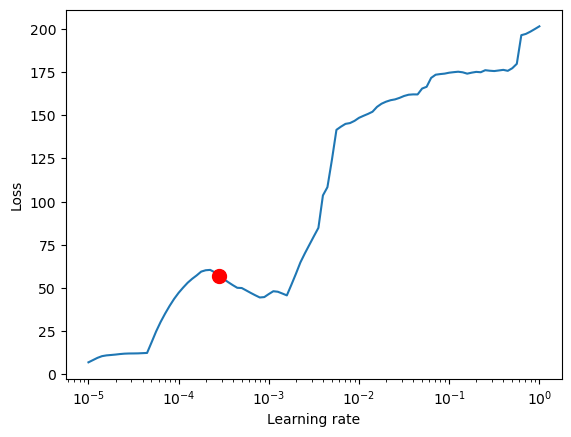

/var/folders/ct/kvv_m0bd68s01xk476lgc7sw0000gn/T/ipykernel_34010/3188746184.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [76]:

# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [78]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    enable_checkpointing=True,
)
net = DeepAR.from_dataset(
    training,
    learning_rate=0.0003,
    hidden_size=30,
    rnn_layers=2,
    loss=MultivariateNormalDistributionLoss(rank=30),
    optimizer="Adam",
)
trainer.fit(
    net,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params | Mode 
--------------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList                         | 0      | train
2 | embeddings             | MultiEmbedding                     | 20     | train
3 | rnn                    | LSTM                               | 13.0 K | train
4 | distribution_projector | Linear                             | 992    | train
--------------------------------------------------------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|█| 220/220 [09:09<00:00,  0.40it/s, v_num=5, train_loss_step=-324.
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 37.49it/s]
Epoch 1: 100%|█| 220/220 [09:16<00:00,  0.40it/s, v_num=5, train_loss_step=-336.
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 34.88it/s]
Epoch 2: 100%|█| 220/220 [09:19<00:00,  0.39it/s, v_num=5, train_loss_step=-348.
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 35.58it/s]
Epoch 3: 100%|█| 220/220 [09:30<00:00,  0.39it/s, v_num=5, train_loss_step=-366.
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 34.63it/s]
Epoch 4: 100%|█| 220/220 [10:02<00:00,  0.36it/s, v_

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|█| 220/220 [10:12<00:00,  0.36it/s, v_num=5, train_loss_step=-1.0


In [172]:

best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)
best_model_path

/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


'/Users/xuximin/Desktop/mds/591/Capstone_SatCast_Trilemma/analysis/lightning_logs/version_5/checkpoints/epoch=29-step=6600.ckpt'

In [155]:
raw_predictions = net.predict(
    df, mode="raw", return_x=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


In [156]:
df_true = df[lambda x : (x.time_idx > x.time_idx.max() - PRED_STEPS) & (x.time_idx <= x.time_idx.max() )]
df_true

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_250_300,time_idx,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,minute_sin,minute_cos
6504,2025-05-11 20:00:00,recommended_fee_economyFee,1.0,1.622954e+06,997971.750000,2550.666667,2.250920e+06,1.473796,3556.000000,1.624676e+06,...,0.0,6504,-0.866025,5.000000e-01,-0.781831,0.62349,0.5,-0.866025,0.000000e+00,1.000000e+00
6505,2025-05-11 20:15:00,recommended_fee_economyFee,1.0,1.746089e+06,997963.166667,2570.333333,2.205875e+06,1.415102,3820.333333,1.747795e+06,...,0.0,6505,-0.866025,5.000000e-01,-0.781831,0.62349,0.5,-0.866025,1.000000e+00,2.832769e-16
6506,2025-05-11 20:30:00,recommended_fee_economyFee,1.0,1.979286e+06,997941.416667,2429.000000,3.173771e+06,2.259357,5216.666667,2.447901e+06,...,0.0,6506,-0.866025,5.000000e-01,-0.781831,0.62349,0.5,-0.866025,5.665539e-16,-1.000000e+00
6507,2025-05-11 20:45:00,recommended_fee_economyFee,1.0,2.028565e+06,876101.583333,1446.333333,1.567622e+06,1.390121,2649.666667,1.587705e+06,...,0.0,6507,-0.866025,5.000000e-01,-0.781831,0.62349,0.5,-0.866025,-1.000000e+00,-1.836970e-16
6508,2025-05-11 21:00:00,recommended_fee_economyFee,1.0,1.457090e+06,935696.500000,2254.333333,1.979036e+06,1.337586,2852.333333,1.159519e+06,...,0.0,6508,-0.707107,7.071068e-01,-0.781831,0.62349,0.5,-0.866025,0.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,2025-05-12 18:45:00,recommended_fee_minimumFee,1.0,1.613380e+06,997963.083333,3756.666667,1.912973e+07,12.971894,21723.000000,8.275349e+06,...,0.0,6595,-1.000000,-1.836970e-16,0.000000,1.00000,0.5,-0.866025,-1.000000e+00,-1.836970e-16
32996,2025-05-12 19:00:00,recommended_fee_minimumFee,1.0,1.652439e+06,997980.083333,3529.333333,1.168404e+07,8.783034,19031.000000,7.614236e+06,...,0.0,6596,-0.965926,2.588190e-01,0.000000,1.00000,0.5,-0.866025,0.000000e+00,1.000000e+00
32997,2025-05-12 19:15:00,recommended_fee_minimumFee,1.0,1.653930e+06,997985.083333,3325.666667,1.071023e+07,7.018166,16706.333333,7.059020e+06,...,0.0,6597,-0.965926,2.588190e-01,0.000000,1.00000,0.5,-0.866025,1.000000e+00,2.832769e-16
32998,2025-05-12 19:30:00,recommended_fee_minimumFee,1.0,1.628465e+06,997960.333333,2991.000000,8.388770e+06,5.185986,14432.666667,6.423460e+06,...,0.0,6598,-0.965926,2.588190e-01,0.000000,1.00000,0.5,-0.866025,5.665539e-16,-1.000000e+00


In [157]:
# Convert raw tensor to NumPy for post-processing
pred_np = raw_predictions.output.prediction.detach().cpu().numpy()
y_pred = np.median(pred_np, axis=-1).flatten()
time_idx = raw_predictions.x["decoder_time_idx"].detach().cpu().numpy().flatten()

# Combine predictions with true values and metadata
df_eval = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        time_idx=time_idx,
        series_id=df_true["series_id"],
        y_true=df_true["target"],
        y_pred = y_pred
    )
)
# Final output: ready for evaluation or visualization
df_eval

,timestamp,time_idx,series_id,y_true,y_pred
6504,2025-05-11 20:00:00,6504,recommended_fee_economyFee,1.0,1.419633
6505,2025-05-11 20:15:00,6505,recommended_fee_economyFee,1.0,1.540206
6506,2025-05-11 20:30:00,6506,recommended_fee_economyFee,1.0,1.591955
6507,2025-05-11 20:45:00,6507,recommended_fee_economyFee,1.0,1.633707
6508,2025-05-11 21:00:00,6508,recommended_fee_economyFee,1.0,1.657894
...,...,...,...,...,...
32995,2025-05-12 18:45:00,6595,recommended_fee_minimumFee,1.0,1.000027
32996,2025-05-12 19:00:00,6596,recommended_fee_minimumFee,1.0,1.000149
32997,2025-05-12 19:15:00,6597,recommended_fee_minimumFee,1.0,1.000033
32998,2025-05-12 19:30:00,6598,recommended_fee_minimumFee,1.0,1.000059


In [158]:
metrics_per_sid = (
    df_eval.groupby("series_id")
    .apply(
        lambda g: pd.Series(
            {
                "MAE": np.abs(g.y_pred - g.y_true).mean(),  # Mean Absolute Error
                "RMSE": np.sqrt(
                    ((g.y_pred - g.y_true) ** 2).mean()
                ),  # Root Mean Square Error
                "MAPE": (
                    np.abs((g.y_pred - g.y_true) / g.y_true).mean() * 100
                ),  # Mean Absolute Percentage Error
            }
        )
    )
    .reset_index()
    .sort_values("RMSE")  # Sort to highlight best-performing series
)

metrics_per_sid

/var/folders/ct/kvv_m0bd68s01xk476lgc7sw0000gn/T/ipykernel_34010/1361063954.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,series_id,MAE,RMSE,MAPE
4,recommended_fee_minimumFee,0.000072,0.000087,0.007248
0,recommended_fee_economyFee,0.461613,0.534382,40.222330
3,recommended_fee_hourFee,3.834008,8.243443,82.510181
2,recommended_fee_halfHourFee,5.002672,10.315879,101.659948
1,recommended_fee_fastestFee,5.511334,11.658690,70.776448


In [159]:
def plot_series(sid, ax=None):
    """
    Plot actual vs. predicted values with prediction intervals for a specific time series.

    Parameters:
    -----------
    sid : str or int
        The series_id identifying the specific time series to plot.
    ax : matplotlib.axes.Axes, optional
        An optional matplotlib Axes object to draw the plot on. If None, a new figure and axes are created.

    Returns:
    --------
    ax : matplotlib.axes.Axes
        The matplotlib Axes object with the plotted data.
    """
    # Subset data for the selected series
    subset = df_eval[df_eval.series_id == sid]

    # Create new figure/axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 5))
    else:
        fig = ax.figure

    # Plot actual values
    ax.plot(subset.timestamp, subset.y_true, label="Actual", color="black")

    # Plot median forecast
    ax.plot(subset.timestamp, subset.y_pred, label="Forecast (Median)", color="blue")


    # Add titles and axis labels
    ax.set_title(f"Series {sid} – 24h Forecast with Quantiles")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Transaction Fee (sats/vB)")

    # Add grid and legend
    ax.grid(True)
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

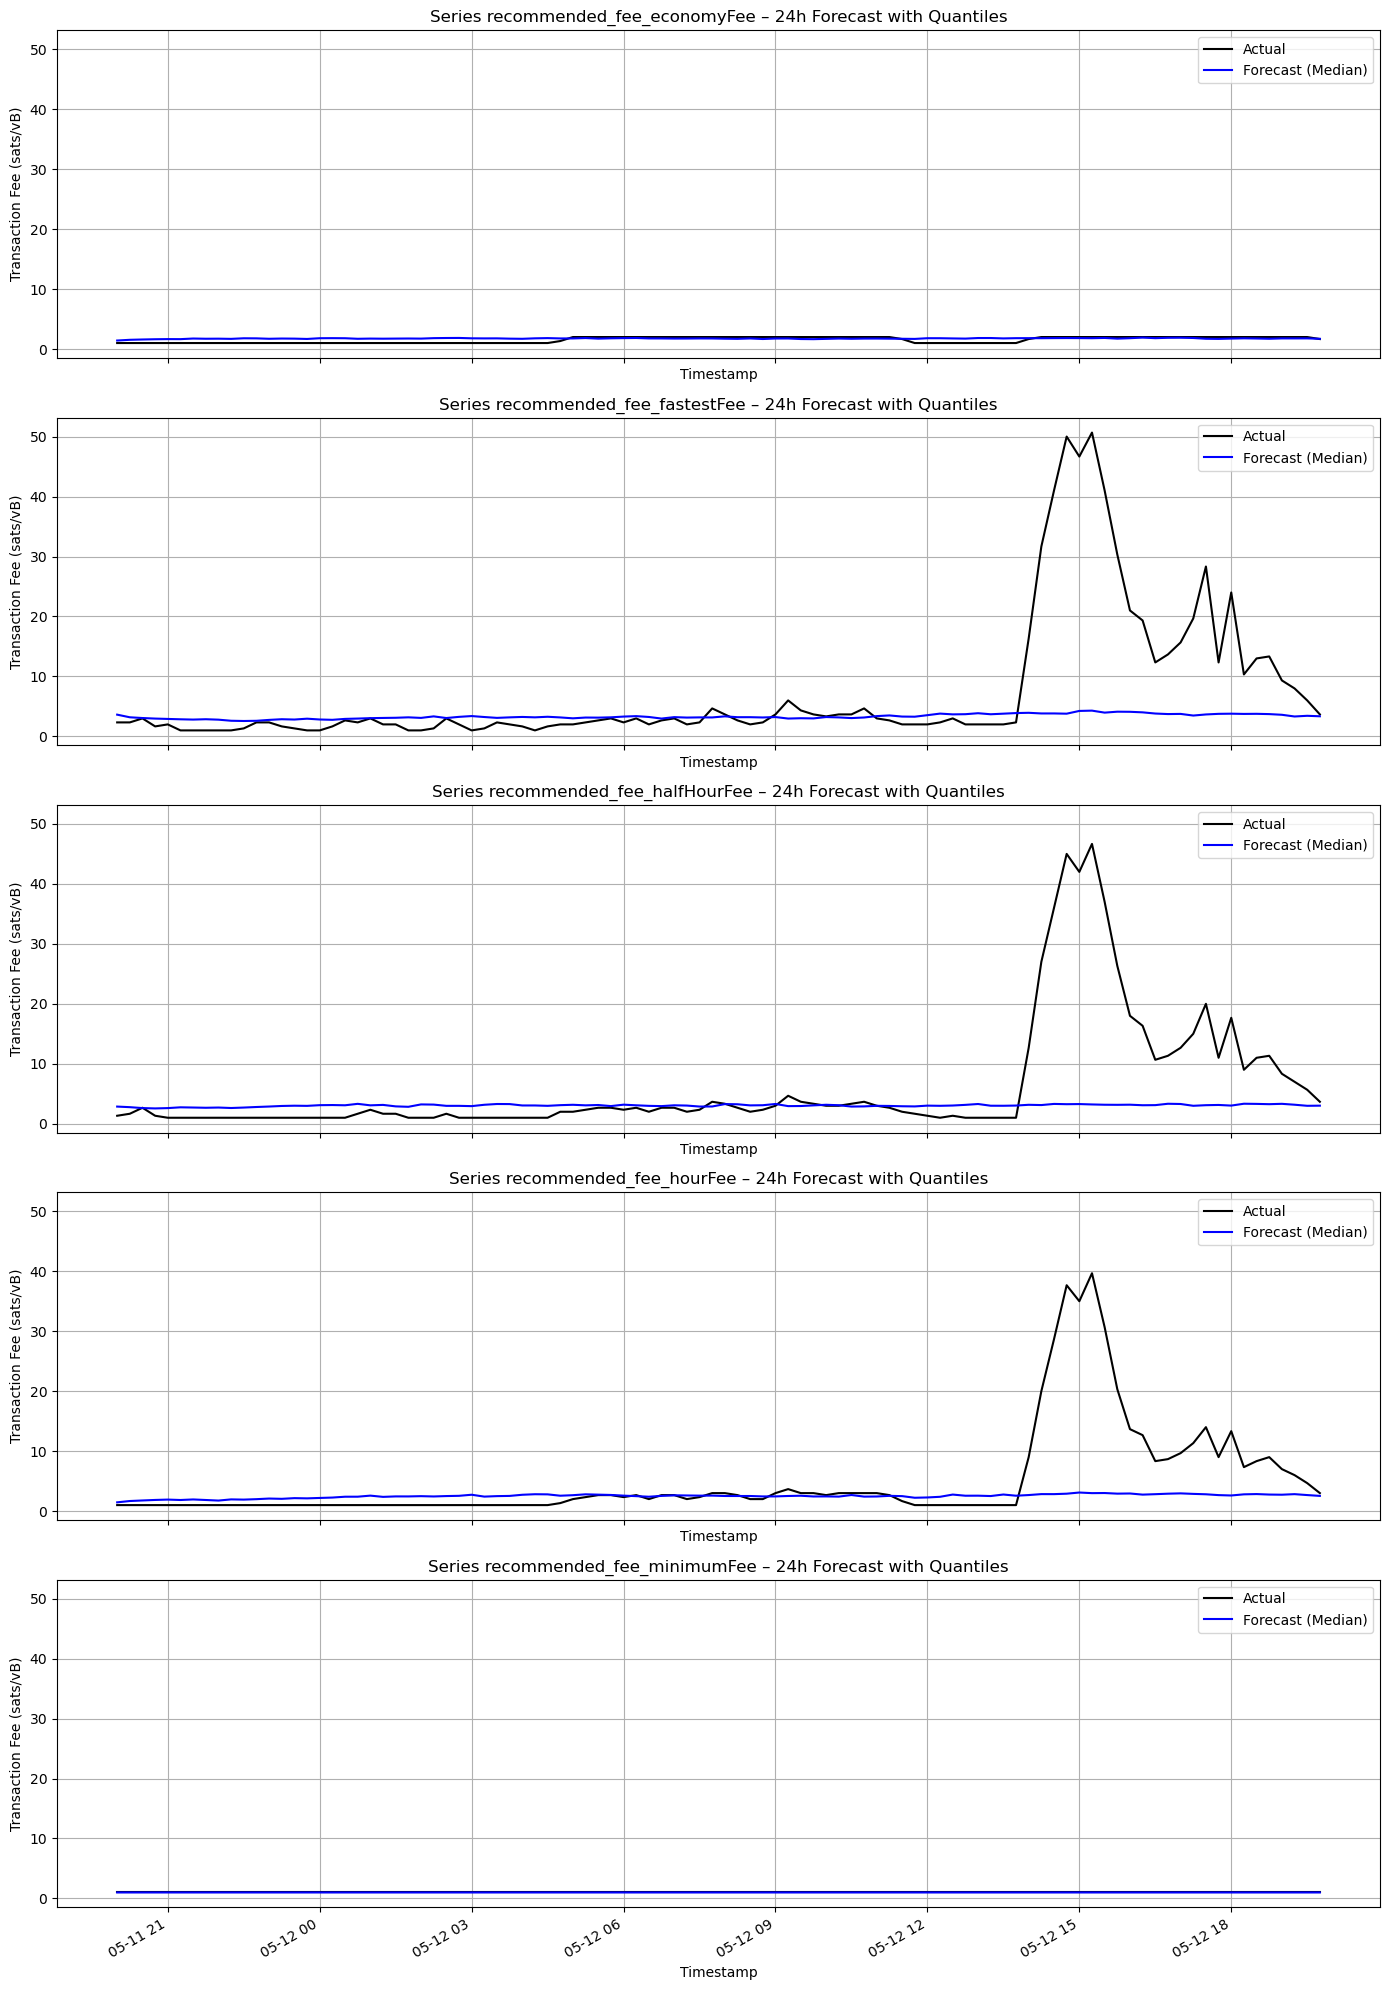

In [160]:
fig, axs = plt.subplots(5, 1, figsize=(14, 20), sharex=True, sharey=True)

# Loop over first 5 unique series_ids and corresponding axes
for i, sid in enumerate(df_eval.series_id.unique()[:5]):
    plot_series(sid, ax=axs[i])  # pass ax explicitly

plt.tight_layout()
plt.show()